In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime
from datetime import timedelta
from fbprophet import Prophet

# enable maximum visiblity in jupyter notebook
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# [Predicting Red Hat Business Value](https://aaa) 

In [2]:
redhat_train = pd.read_csv("input/predict-red-hat-business-value/act_train.csv",parse_dates=['date'])
redhat_test = pd.read_csv("input/predict-red-hat-business-value/act_test.csv",parse_dates=['date'])
redhat_ppl = pd.read_csv("input/predict-red-hat-business-value/people.csv",parse_dates=['date'])

In [3]:
redhat_train.shape

(2197291, 15)

In [4]:
redhat_test.shape

(498687, 14)

# 1 EDA 

## 1.1 Is there any class imbalance 

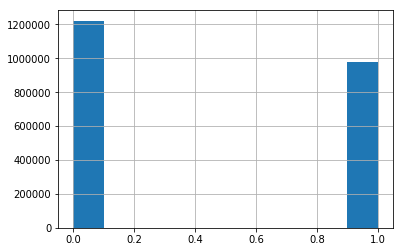

In [5]:
redhat_train.outcome.hist()

In [6]:
redhat_train.head(1)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0


In [7]:
redhat_test.head(1)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN


In [8]:
redhat_ppl.head(1)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


## 1.2 Statistic Facts about the files 

In [9]:
redhat_train.describe(include='all').iloc[0:2,:]

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
count,2197291,2197291,2197291,2197291,157615,157615,157615,157615,157615,157615,157615,157615,157615,2039676,2197291.0
unique,151295,2197291,411,7,51,32,11,7,7,5,8,18,19,6515,NaN


In [10]:
redhat_test.describe(include='all').iloc[0:2,:]

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
count,498687,498687,498687,498687,40092,40092,40092,40092,40092,40092,40092,40092,40092,458595
unique,37823,498687,411,7,48,31,11,7,6,5,8,18,19,3961


In [11]:
redhat_test.describe(include='all').iloc[0:2,:]

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
count,498687,498687,498687,498687,40092,40092,40092,40092,40092,40092,40092,40092,40092,458595
unique,37823,498687,411,7,48,31,11,7,6,5,8,18,19,3961


## 1.3 Is there any overlapping in people ids? 

In [12]:
redhat_train.people_id.map(lambda x:float(x.split('_')[1])).max()

398238.0

In [13]:
redhat_train.people_id.map(lambda x:float(x.split('_')[1])).min()

2.0

In [14]:
len(set(redhat_train.people_id.map(lambda x:float(x.split('_')[1])))&
   set(redhat_test.people_id.map(lambda x:float(x.split('_')[1]))))

0

In [15]:
len(set(redhat_train.people_id.map(lambda x:float(x.split('_')[1])))-
   set(redhat_test.people_id.map(lambda x:float(x.split('_')[1]))))

151295

In [16]:
set(redhat_test.people_id).issubset(set(redhat_train.people_id))

False

In [17]:
pd.concat([redhat_train.groupby(['people_id']).size(),
          redhat_test.groupby(['people_id']).size()],
          axis=1,sort=False).rename(columns={0:'train',1:'test'},
                                   ).sort_values(by='train',ascending=False)[1:10]

,train,test
ppl_370270,53668.0,NaN
ppl_105739,45936.0,NaN
ppl_54699,23969.0,NaN
ppl_64887,7052.0,NaN
ppl_250020,4293.0,NaN
ppl_351668,3144.0,NaN
ppl_36839,3059.0,NaN
ppl_372923,2365.0,NaN
ppl_265578,1539.0,NaN


In [18]:
pd.concat([redhat_train.groupby(['people_id']).size(),
          redhat_test.groupby(['people_id']).size()],
          axis=1,sort=False).rename(columns={0:'train',1:'test'},
                                   ).sort_values(by='test',ascending=False)[1:10]

,train,test
ppl_269574,NaN,948.0
ppl_137922,NaN,868.0
ppl_60553,NaN,532.0
ppl_125856,NaN,526.0
ppl_358338,NaN,519.0
ppl_306851,NaN,490.0
ppl_162444,NaN,482.0
ppl_299382,NaN,477.0
ppl_21718,NaN,449.0


## 1.4 Get an idea about date distribution in train and test dataset 

In [19]:
for d in ['date']:
    print('Start of ' + d + ': ' + str(redhat_train[d].min().date()))
    print(' End of ' + d + ': ' + str(redhat_train[d].max().date()))
    print('Range of ' + d + ': ' + str(redhat_train[d].max()-redhat_train[d].min()) + '\n')

Start of date: 2022-07-17
 End of date: 2023-08-31
Range of date: 410 days 00:00:00



In [20]:
for d in ['date']:
    print('Start of ' + d + ': ' + str(redhat_test[d].min().date()))
    print(' End of ' + d + ': ' + str(redhat_test[d].max().date()))
    print('Range of ' + d + ': ' + str(redhat_test[d].max()-redhat_test[d].min()) + '\n')

Start of date: 2022-07-17
 End of date: 2023-08-31
Range of date: 410 days 00:00:00



## 1.5 Get an idea about group_1 distribution in people dataset 

In [21]:
redhat_ppl.groupby(['group_1']).size().sort_values(ascending=False)[:10]

group_1
group 17304    77314
group 667       1538
group 8386      1046
group 9280       666
group 450        659
group 1482       484
group 15723      461
group 3229       423
group 17899      414
group 3598       365
dtype: int64

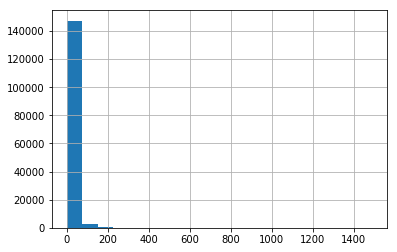

In [22]:
redhat_train.groupby(['people_id']).size().sort_values(ascending=False)[10:].hist(bins=20)

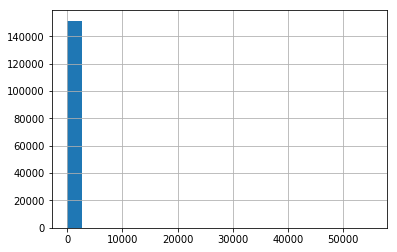

In [23]:
redhat_train.groupby(['people_id']).size().sort_values(ascending=False).hist(bins=20)

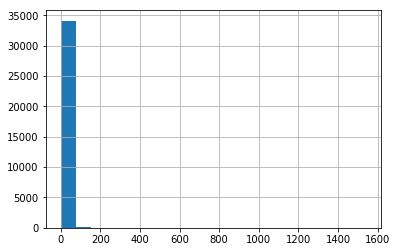

In [24]:
redhat_ppl.groupby(['group_1']).size().sort_values(ascending=False)[1:].hist(bins=20)

# 2. Data Preprocessing 

## 2.1 Merge train and test dataset with people information

In [25]:
redhat_train = redhat_train[['people_id','activity_id','date','activity_category','char_10','outcome']]
redhat_test = redhat_test[['people_id','activity_id','date','activity_category','char_10']]
df_redhat_train = pd.merge(redhat_train,redhat_ppl, on='people_id')
df_redhat_test = pd.merge(redhat_test,redhat_ppl, on='people_id')

In [26]:
pd.concat([df_redhat_train.groupby(['group_1']).size(),
          df_redhat_test.groupby(['group_1']).size()],
          axis=1,sort=False).rename(columns={0:'train',1:'test'}).sort_values(by='train',ascending=False)[1:10]

,train,test
group 27940,53668.0,NaN
group 667,15865.0,3904.0
group 8386,7929.0,2194.0
group 20472,7053.0,5.0
group 9280,5492.0,1166.0
group 17899,4767.0,1224.0
group 450,3867.0,989.0
group 7256,3759.0,769.0
group 1482,3272.0,883.0


** stried moving out most group in train but not in test, but didn't improve the score**

In [27]:
df_redhat_train_x = df_redhat_train.drop('outcome',axis=1).copy()
df_redhat_train_y = df_redhat_train['outcome'].copy()
df_redhat_test_x = df_redhat_test.copy()

In [28]:
df_redhat_train.shape

(2197291, 46)

# 3 Feature Engineering 

## 3.1 Impute missing values accordingly 

In [29]:
# process the nan values and categorical columns
for i in df_redhat_train_x.columns:
    if np.dtype(df_redhat_train_x[i])==np.dtype('object') and i!='activity_id' and i!='people_id' and i!='group_1':
        df_redhat_train_x[i].fillna(df_redhat_train_x[i].mode()[0],inplace=True)
        df_redhat_train_x[i] = df_redhat_train_x[i].map(lambda x:int(x.split(' ')[1]))
    elif np.dtype(df_redhat_train_x[i])==np.dtype('bool'):
        df_redhat_train_x[i] = df_redhat_train_x[i].map(lambda x:int(x))
    else:
        pass
for i in df_redhat_test_x.columns:
    if np.dtype(df_redhat_test_x[i])==np.dtype('object') and i!='activity_id' and i!='people_id' and i!='group_1':
        df_redhat_test_x[i].fillna(df_redhat_test_x[i].mode()[0],inplace=True)
        df_redhat_test_x[i] = df_redhat_test_x[i].map(lambda x:int(x.split(' ')[1]))
    elif np.dtype(df_redhat_test_x[i])==np.dtype('bool'):
        df_redhat_test_x[i] = df_redhat_test_x[i].map(lambda x:int(x))
    else:
        pass

## 3.2 Process date information 

In [30]:
df_redhat_train_x['Day_x'] = df_redhat_train_x['date_x'].map(lambda x:x.day)
df_redhat_train_x['Month_x'] = df_redhat_train_x['date_x'].map(lambda x:x.month)
df_redhat_train_x['Year_x'] = df_redhat_train_x['date_x'].map(lambda x:x.year)
df_redhat_test_x['Day_x'] = df_redhat_test_x['date_x'].map(lambda x:x.day)
df_redhat_test_x['Month_x'] = df_redhat_test_x['date_x'].map(lambda x:x.month)
df_redhat_test_x['Year_x'] = df_redhat_test_x['date_x'].map(lambda x:x.year)
df_redhat_train_x['Day_y'] = df_redhat_train_x['date_y'].map(lambda x:x.day)
df_redhat_train_x['Month_y'] = df_redhat_train_x['date_y'].map(lambda x:x.month)
df_redhat_train_x['Year_y'] = df_redhat_train_x['date_y'].map(lambda x:x.year)
df_redhat_test_x['Day_y'] = df_redhat_test_x['date_y'].map(lambda x:x.day)
df_redhat_test_x['Month_y'] = df_redhat_test_x['date_y'].map(lambda x:x.month)
df_redhat_test_x['Year_y'] = df_redhat_test_x['date_y'].map(lambda x:x.year)

## 3.3 Create a new feature - mean outcome by group

In [31]:
outcome_mean_by_group = df_redhat_train.groupby(['group_1'])['outcome'].mean().to_frame().reset_index()
outcome_mean_by_group_dict = dict(zip(outcome_mean_by_group['group_1'],outcome_mean_by_group['outcome']))
df_redhat_train_x['outcome_by_group'] = df_redhat_train_x['group_1'].map(lambda x:outcome_mean_by_group_dict.get(x))
df_redhat_test_x['outcome_by_group'] = df_redhat_test_x['group_1'].map(lambda x:outcome_mean_by_group_dict.get(x))
df_redhat_test_x['outcome_by_group'] = df_redhat_test_x.groupby(['people_id'])['outcome_by_group'].transform(lambda x:x.fillna(x.mean()))
df_redhat_test_x['outcome_by_group'] = df_redhat_test_x.groupby(['activity_category'])['outcome_by_group'].transform(lambda x:x.fillna(x.mean()))

## 3.4 Transform group_1 feature 

In [32]:
df_redhat_train_x['group_1'] = df_redhat_train_x['group_1'].map(lambda x:int(x.split(' ')[1]))
df_redhat_test_x['group_1'] = df_redhat_test_x['group_1'].map(lambda x:int(x.split(' ')[1]))
df_redhat_train_x = df_redhat_train_x = df_redhat_train_x.drop(['people_id','activity_id','date_x','date_y'],axis=1)
df_redhat_test_x = df_redhat_test_x = df_redhat_test_x.drop(['people_id','activity_id','date_x','date_y'],axis=1)

# 4 Feed data into model and make submission 

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
redhat_X_train, redhat_X_test, redhat_Y_train, redhat_Y_test = train_test_split(df_redhat_train_x,df_redhat_train_y,test_size=0.3,random_state=0)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

C:\Users\wzq\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(redhat_X_train,redhat_Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
roc_auc_score =(redhat_Y_test.values,random_forest.predict_proba(redhat_X_test)[:,1])

In [37]:
output = pd.DataFrame({'activity_id':df_redhat_test['activity_id'].values,
                      'outcome':random_forest.predict_proba(df_redhat_test_x)[:,1]})
output.to_csv('red_hat.csv',index=False)

# [Rossmann Store Sales](https://aaa) 

In [38]:
rossmann_train = pd.read_csv('input/rossmann-store-sales/train.csv',parse_dates=['Date'])
rossmann_test = pd.read_csv('input/rossmann-store-sales/test.csv',parse_dates=['Date'])
rossmann_store = pd.read_csv('input/rossmann-store-sales/store.csv')

C:\Users\wzq\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
# any day and store with 0 sales is ignored in scoring
rossmann_train = rossmann_train[rossmann_train.Sales !=0]

In [40]:
rossmann_store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [41]:
print('Training data starts from : ' + str(rossmann_train['Date'].min().date()) +
     ' ends on ' + str(rossmann_train['Date'].max().date()))
print('Testing data starts from : ' + str(rossmann_test['Date'].min().date()) + 
     ' ends on ' + str(rossmann_test['Date'].max().date()))

Training data starts from : 2013-01-01 ends on 2015-07-31
Testing data starts from : 2015-08-01 ends on 2015-09-17


# 1. Feature engineering 

## 1.1 Process missing value in Store Dataset 

In [42]:
rossmann_store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [43]:
rossmann_store.CompetitionDistance.fillna(rossmann_store.CompetitionDistance.mean())
rossmann_store.CompetitionOpenSinceMonth = rossmann_store.groupby(['StoreType','Assortment'])['CompetitionOpenSinceMonth'].transform(lambda x: x.fillna(x.mode()))
rossmann_store.CompetitionOpenSinceYear = rossmann_store.groupby(['StoreType','Assortment'])['CompetitionOpenSinceYear'].transform(lambda x:x.fillna(x.median()))
rossmann_store.CompetitionOpenSinceYear = rossmann_store.CompetitionOpenSinceYear.fillna(rossmann_store.CompetitionOpenSinceYear.mode()[0])
rossmann_store.CompetitionOpenSinceMonth = rossmann_store.CompetitionOpenSinceMonth.fillna(rossmann_store.CompetitionOpenSinceMonth.mode()[0])

In [44]:
rossmann_store.loc[rossmann_store[rossmann_store.Promo2==0].index.values,
                  'Promo2SinceWeek'] = 0
rossmann_store.loc[rossmann_store[rossmann_store.Promo2==0].index.values,
                  'Promo2SinceYear'] = 0
rossmann_store.loc[rossmann_store[rossmann_store.Promo2==0].index.values,
                  'PromoInterval'] = 'None'
rossmann_store.Promo2SinceWeek = rossmann_store.groupby(['StoreType','Assortment'])['Promo2SinceWeek'].transform(lambda x:x.fillna(x.mode()))
rossmann_store.Promo2SinceYear = rossmann_store.groupby(['StoreType','Assortment'])['Promo2SinceYear'].transform(lambda x:x.fillna(x.mode()))
rossmann_store.PromoInterval = rossmann_store.groupby(['StoreType','Assortment'])['PromoInterval'].transform(lambda x:x.fillna(x.mode()))

In [45]:
rossmann_store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None
5,6,a,a,310.0,12.0,2013.0,0,0.0,0.0,None
6,7,a,c,24000.0,4.0,2013.0,0,0.0,0.0,None
7,8,a,a,7520.0,10.0,2014.0,0,0.0,0.0,None
8,9,a,c,2030.0,8.0,2000.0,0,0.0,0.0,None
9,10,a,a,3160.0,9.0,2009.0,0,0.0,0.0,None


## 1.2 Transform categorical features 

In [46]:
rossmann_store = pd.get_dummies(rossmann_store,columns=['StoreType','Assortment','PromoInterval'])

## 1.3 Process data information 

In [47]:
rossmann_train['Day'] = rossmann_train.Date.map(lambda x:x.day)
rossmann_train['Month'] = rossmann_train.Date.map(lambda x:x.month)
rossmann_train['Year'] = rossmann_train.Date.map(lambda x:x.year)
rossmann_test['Day'] = rossmann_test.Date.map(lambda x:x.day)
rossmann_test['Month'] = rossmann_test.Date.map(lambda x:x.month)
rossmann_test['Year'] = rossmann_test.Date.map(lambda x:x.year)
#rossmann_train.drop(['Date'],axis=1,inplace=True) 
#rossmann_test.drop(['Date'],axis=1,inplace=True)
rossmann_train.StateHoliday = rossmann_train.StateHoliday.map({0:'0'})
rossmann_test.StateHoliday = rossmann_test.StateHoliday.map({0:'0'})
rossmann_train = pd.get_dummies(rossmann_train,columns=['StateHoliday'])
rossmann_test = pd.get_dummies(rossmann_test,columns=['StateHoliday'])

## 1.4 Create a statistical features based on Sales history - using Prophet 

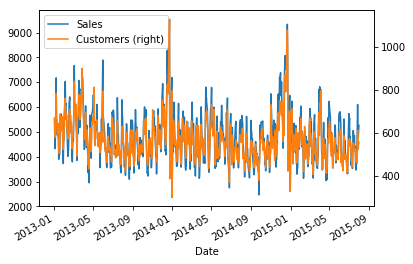

In [48]:
ax = rossmann_train[rossmann_train.Store==1].sort_values(by='Date')[['Date','Sales']].set_index('Date').plot()
rossmann_train[rossmann_train.Store==1].sort_values(by='Date')[['Date','Customers']].set_index('Date').plot(secondary_y=True,ax=ax)

In [49]:
max_train_date = rossmann_train.Date.max().date()
min_train_date = rossmann_train.Date.min().date()
max_test_date = rossmann_test.Date.max().date()
min_test_date = rossmann_test.Date.min().date()

In [50]:
all_sales_stats = pd.DataFrame([])
for i in rossmann_train.Store.unique():
    train_calendar = pd.DataFrame({'Date':[min_train_date+timedelta(days=i+1) for i in range((max_train_date-min_train_date).days)]})
    train_sales = train_calendar.set_index('Date').join(rossmann_train[rossmann_train.Store==i
                                                                      ].sort_values(by='Date')[['Date','Sales']].set_index('Date'),how='left').reset_index().fillna(0)
    train_sales.columns = ['ds','y']
    train_sales_prophet = Prophet(weekly_seasonality=True,yearly_seasonality=True).fit(train_sales)
    train_sales_prophet_temp = train_sales_prophet.make_future_dataframe(periods=48,freq='D')
    train_sales_forecast_temp = train_sales_prophet.predict(train_sales_prophet_temp)
    train_sales_forecast = train_sales_forecast_temp[['ds','yhat','yhat_upper']].copy()
    
    #train_customer_forecast['yhat'] = train_customer_customers_forecast['yhat'].map(lambda x: 0 if x<0 else x)
    train_sales_forecast.rename(columns={'ds':'Date'},inplace=True)
    train_sales_forecast['Store'] = i
    all_sales_stats = all_sales_stats.append(train_sales_forecast,ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\wzq\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [51]:
rossmann_test = rossmann_test.set_index(['Store','Date']).join(all_sales_stats.set_index(['Store','Date']),how='left').reset_index()
rossmann_train = rossmann_train.set_index(['Store','Date']).join(all_sales_stats.set_index(['Store','Date']),how='left').reset_index()

In [52]:
rossmann_train.head()

,Store,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,StateHoliday_0,yhat,yhat_upper
0,1,2015-07-31,5,5263,555,1,1,1,31,7,2015,0,4331.763626,5877.194721
1,2,2015-07-31,5,6064,625,1,1,1,31,7,2015,0,4410.116239,6112.795669
2,3,2015-07-31,5,8314,821,1,1,1,31,7,2015,0,6797.010794,9450.673176
3,4,2015-07-31,5,13995,1498,1,1,1,31,7,2015,0,9297.191289,12010.387773
4,5,2015-07-31,5,4822,559,1,1,1,31,7,2015,0,4758.223300,6379.802389


In [53]:
rossmann_test.head()

,Store,Date,Id,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,yhat,yhat_upper
0,1,2015-09-17,1,4,1.0,1,0,17,9,2015,3607.082863,5173.667196
1,3,2015-09-17,2,4,1.0,1,0,17,9,2015,6097.594753,8617.187870
2,7,2015-09-17,3,4,1.0,1,0,17,9,2015,8278.397177,11169.935585
3,8,2015-09-17,4,4,1.0,1,0,17,9,2015,6919.093725,8709.289366
4,9,2015-09-17,5,4,1.0,1,0,17,9,2015,6603.738861,8678.045912


In [54]:
df_rossmann_train = rossmann_train.merge(rossmann_store,how='left')
df_rossmann_test = rossmann_test.merge(rossmann_store,how='left')

In [55]:
df_rossmann_train_x = df_rossmann_train.drop(['Sales','Customers'],axis=1).copy()
df_rossmann_train_y = df_rossmann_train['Sales'].copy()
df_rossmann_test_x = df_rossmann_test.drop(['Id'],axis=1).copy()

In [56]:
len(df_rossmann_train_x[df_rossmann_train_x['Date']>datetime.strptime('2015-07-10','%Y-%m-%d')].index.values)

20128

In [57]:
rossmann_X_train = df_rossmann_train_x.loc[df_rossmann_train_x[df_rossmann_train_x['Date']<=datetime.strptime('2015-07-10','%Y-%m-%d')].index.values].copy()
rossmann_Y_train = df_rossmann_train_y.loc[df_rossmann_train_x[df_rossmann_train_x['Date']<=datetime.strptime('2015-07-10','%Y-%m-%d')].index.values].copy()
rossmann_X_test = df_rossmann_train_x.loc[df_rossmann_train_x[df_rossmann_train_x['Date']>datetime.strptime('2015-07-10','%Y-%m-%d')].index.values].copy()
rossmann_Y_test = df_rossmann_train_y.loc[df_rossmann_train_x[df_rossmann_train_x['Date']>datetime.strptime('2015-07-10','%Y-%m-%d')].index.values].copy()
rossmann_X_train = rossmann_X_train.drop('Date',axis=1).copy()
rossmann_X_test = rossmann_X_test.drop('Date',axis=1).copy()

In [58]:
rossmann_X_train,rossmann_X_test = rossmann_X_train.align(rossmann_X_test,join='inner',axis=1)
rossmann_X_train,df_rossmann_test_x = rossmann_X_train.align(df_rossmann_test_x,join='inner',axis=1)

# 2 Feed data into model and make submission 

In [59]:
def rmspe(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)/y_true)**2)
from sklearn.metrics import make_scorer
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_scroe(model,rossmann_X_train,rossmann_Y_train.vlaues.ravel(),scoring = rmspe_scorer,cv=5))
    return (rmse)
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model,rossmann_X_test,rossmann_Y_test.values.ravel(),scoring= rmspe_scorer,cv=5))
    return (rmse)

In [61]:
df_rossmann_test_x.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,yhat,yhat_upper,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1,4,1.0,1,0,17,9,2015,3607.082863,5173.667196,1270.0,9.0,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,1
1,3,4,1.0,1,0,17,9,2015,6097.594753,8617.187870,14130.0,12.0,2006.0,1,14.0,2011.0,1,0,0,0,1,0,0,0,1,0,0
2,7,4,1.0,1,0,17,9,2015,8278.397177,11169.935585,24000.0,4.0,2013.0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1
3,8,4,1.0,1,0,17,9,2015,6919.093725,8709.289366,7520.0,10.0,2014.0,0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1
4,9,4,1.0,1,0,17,9,2015,6603.738861,8678.045912,2030.0,8.0,2000.0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1


In [62]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
from sklearn.model_selection import cross_val_score

In [66]:
rfr = RandomForestRegressor(bootstrap=True, max_depth=80, n_estimators=100)

In [67]:
rossmann_X_train.fillna(0,inplace=True)

In [68]:
rfr.fit(rossmann_X_train,rossmann_Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [69]:
df_rossmann_test_x.shape

(41088, 27)

In [70]:
dict(zip(df_rossmann_test_x.columns,rfr.feature_importances_))

{'Store': 0.006664291780796308,
 'DayOfWeek': 0.027783229128542346,
 'Open': 0.0,
 'Promo': 0.11837796731004388,
 'SchoolHoliday': 0.003934660462561168,
 'Day': 0.03745907556491091,
 'Month': 0.019760734737089402,
 'Year': 0.005535725121836896,
 'yhat': 0.7003052157759402,
 'yhat_upper': 0.052016152805279055,
 'CompetitionDistance': 0.007912133885718575,
 'CompetitionOpenSinceMonth': 0.0034264917533826174,
 'CompetitionOpenSinceYear': 0.004127948722742839,
 'Promo2': 0.0003081044573925257,
 'Promo2SinceWeek': 0.00316924888064944,
 'Promo2SinceYear': 0.0023148471667852858,
 'StoreType_a': 0.0008518405850332331,
 'StoreType_b': 0.00042682691811691555,
 'StoreType_c': 0.0007240164481582502,
 'StoreType_d': 0.0008055822476071994,
 'Assortment_a': 0.0006910118224961745,
 'Assortment_b': 0.00021218932938428647,
 'Assortment_c': 0.0006439188756125903,
 'PromoInterval_Feb,May,Aug,Nov': 0.0006697395476246884,
 'PromoInterval_Jan,Apr,Jul,Oct': 0.001120111640532408,
 'PromoInterval_Mar,Jun,Sept,D

In [71]:
df_rossmann_test_x.Open.fillna(1,inplace=True)

In [72]:
df_rossmann_test_x.fillna(0,inplace=True)

In [73]:
pd.DataFrame({'Id':df_rossmann_test['Id'].values,
             'Sales':rfr.predict(df_rossmann_test_x.values)}).to_csv('rossmann_submission_added_customer_in_test_using_prophet.csv',index=False)